#### Week 1: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 1 - Notebook 2

# Overview

Welcome to Week 1: Part 2 of this course!  In our first notebook we handled the data preprocessing steps which included:
- Chunking/splitting
- Vectorization of text
- Combining with metadata
- Saving to disk

We'll move on now to working with **Weaviate** to perform the following operations:
- Index Configuration
- Data Indexing
- Keyword search
- Vector search
- OPTIONAL: Searching with Filters

![weaviate]( 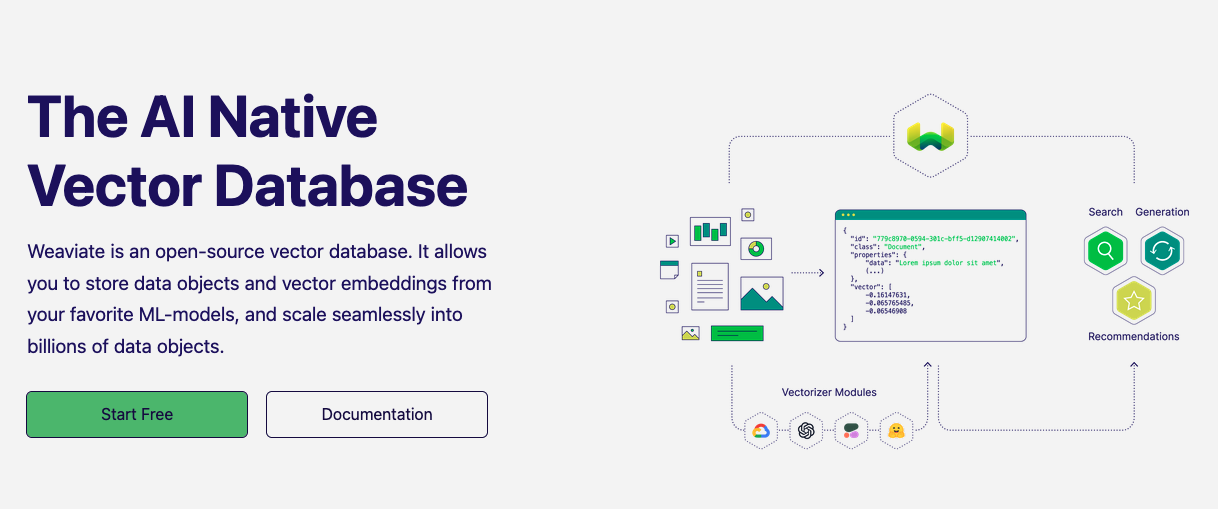)

# Approach
As a reminder, we will cover a total of three notebooks this week -

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* Part 2 **(THIS NOTEBOOK)**:
  * Index data on Weaviate database
  * Search over data
* Part 2.5:
  * Benchmark retrieval results

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch_diagram]( 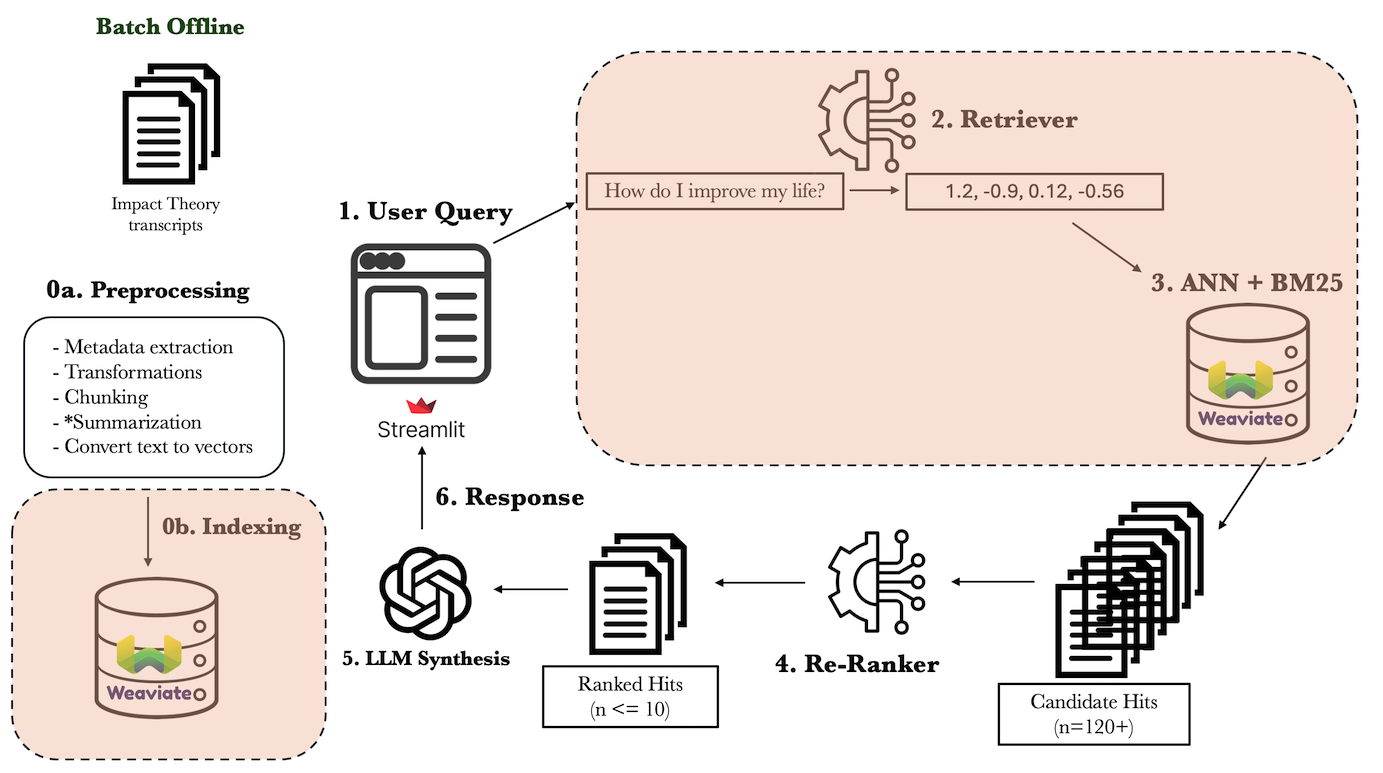)

In [3]:
import sys
sys.path.append('../')

#load from local .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

#external files
from src.preprocessor.preprocessing import FileIO
from src.database.weaviate_interface_v4 import WeaviateIndexer, WeaviateWCS
from src.database.database_utils import get_weaviate_client

#standards
import os
import time
import json
from typing import List
from tqdm import tqdm
from rich import print  # nice library that provides improved printing output (overrides default print function)

## Setup

<div class="alert alert-danger"><h3>This Notebook assumes that you have 
    already created an account with Weaviate and have created a Weaviate instance on Weaviate Cloud Services (WCS)</h3></div>

1. If you have not created a Weviate account, go here: [Weaviate Account setup video](https://www.loom.com/share/0ad6f80bcb0e4a3aa7c7ac032596ed89?sid=0cdf3b6e-f251-4eda-bf28-b1d2d4af70e7)
2. If you have not created a Weaviate cluster, go here: [Weaviate Cluster setup video](https://www.loom.com/share/cccd9b52fa374c3c97dc84b6854ab14b?sid=cda33892-bb9e-42c3-8126-06ac8d7cc6fd)

### Instantiate Weaviate Client

The `WeaviateWCS` Class is a convenient wrapper around the Weaviate python API (version 4).  We'll use it to create a Weaviate client to connect with our Weaviate Cloud instance.  
For this course use the WeaviateWCS wrapper because it comes prebuilt with several useful functions.  If you're curious and want to access all python v4 attributes/methods you can access them using the private `WeaviateWCS` `_client` attribute like this: `client._client`. 

Instantiating the Class requires 3 main pieces of information that will change from user to user:
- a model name or path for use with vector searches - this is the model that will create an embedding from the query string
- the Weaviate instance endpoint 
- your personal Weaviate api key

In a production setting you'd have to account for security layers, but for this course we'll be working with a dev instance. 

In [4]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']
model_path = 'sentence-transformers/all-MiniLM-L6-v2'

#instantiate client,
client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_path)
client._client.is_live()

# Alternatively you can simply use the get_weaviate_client
# convenice function, which assumes a default config
# client = get_weaviate_client()

/var/folders/zz/f8svd2n5583dff32w3y0k5zh0000gn/T/ipykernel_15559/4191683488.py:7: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.103.34.222', 51971), raddr=('34.149.137.116', 443)>
  client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_path)


True

### Load Saved Data from Disk (from previous notebook)

In [5]:
data_path = "../data/huberman-minilmL6-256.parquet"

data = FileIO.load_parquet(data_path)

Shape of data: (23905, 13)
Memory Usage: 2.37+ MB


## Intuition
***

Now that we've instantiated our Weaviate client as a connection with our Weaviate Host in the cloud, as well as loaded our data in memory, we're prepared to Index our data.  We'll follow the below steps:  

1. **Define a schema of Collection properties**: This step allows us to be precise on data types, filterablitiy, and indexability.
2. **Define a Collection configuration**: This is our chance to configure how we want our Collection (index) to run.  As part of this configuration we'll insert our schema of properties.
3. **Index Data on Weaviate**: Index our data using batch uploads. 

Including a **Terms Comparison Table** below (hope this helps avoid more confustion that it creates 😊).  
Terms are ranked in increasing order of information granularity i.e. a `Collection` is a collection of `Data Objects` which are in turn a collection of `Properties`.



<table style='float:left'>
    <tr>
        <th><h3>Weaviate Term</h3></th>
        <th><h3>OpenSearch Equivalent</h3></th>
        <th><h3>Relational DB Equivalent</h3></th>
    </tr>
    <tr>
        <td>Collection</td>
        <td>Index</td>
        <td>Table</td>
    </tr>
    <tr>
        <td>Data Object</td>
        <td>Document</td>
        <td>Row</td>
    </tr>
    <tr>
        <td>Property</td>
        <td>Field</td>
        <td>Column</td>
    </tr>
</table>

***

### Step 1 --> Define a Schema of Collection Properties

Weaviate supports an auto-schema option wherein properties are defined during data ingestion, however, for greater precision we are going to manually define each of our properties.  We'll define the following parameters for each property:
   - `name`: the name of the property, for simplicity we'll ensure that each name corresponds with each key/field of each entry in our data
   - `dataType`: the type of data i.e. `text`, `number`, `date`, etc.
   - `indexFilterable`: should we be able to filter on this property? 
   - `indexSearchable`: should we be able to search over this property?  Do not set this property to "true" if you do not intend to search over this property.
   - Property example:
        ```
           [
             Property(
              'name': 'video_id',
              'dataType': "DataType.TEXT: 'text'>",
              'indexFilterable': True,
              'indexSearchable': True
             ),
             Property(
              'name': 'length_seconds',
              'dataType': "<DataType.INT: 'int'>",
              'indexFilterable': True,
              'indexSearchable': False
             )...
            ]
        ```

<div class="alert alert-success"><h5>In the interest of time, I've created schema template that can be imported as an example to get us started. Import the pre-defined schema of class properties from the class_templates.py file and print to screen.  </h5></div>

In [6]:
from src.database.properties_template import properties

print(properties)

[
    Property(
        name='video_id',
        dataType=<DataType.TEXT: 'text'>,
        description='Unique identifier of the video episode',
        indexFilterable=True,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='title',
        dataType=<DataType.TEXT: 'text'>,
        description='Title of the video episode',
        indexFilterable=True,
        indexSearchable=True,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='length_seconds',
        dataType=<DataType.INT: 'int'>,
        description='Length of the video episode in seconds',
        indexFilterable=True,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='thumbnail_url',
        dataType=<DataType.TEXT: 'text'>,
        description='URL of the video episode thumbnail picture',
        indexFilterable=False,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='keywords',
        dataType=<DataType.TEXT_ARRAY: 'text[]'>,
        description='Keywords associated with the video episode',
        indexFilterable=True,
        indexSearchable=True,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='summary',
        dataType=<DataType.TEXT: 'text'>,
        description='Short summary of the episode content',
        indexFilterable=False,
        indexSearchable=True,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='view_count',
        dataType=<DataType.INT: 'int'>,
        description='Number of views the video episode has received',
        indexFilterable=True,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='episode_num',
        dataType=<DataType.INT: 'int'>,
        description='User-defined episode number in the series',
        indexFilterable=True,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='doc_id',
        dataType=<DataType.TEXT: 'text'>,
        description='Unique document identifier created during preprocessing of documents',
        indexFilterable=True,
        indexSearchable=False,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='content',
        dataType=<DataType.TEXT: 'text'>,
        description='Chunk of text from the video episode',
        indexFilterable=False,
        indexSearchable=True,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='guest',
        dataType=<DataType.TEXT: 'text'>,
        description='Guests featured in the video episode',
        indexFilterable=True,
        indexSearchable=True,
        nestedProperties=None,
        skip_vectorization=False,
        tokenization=None,
        vectorize_property_name=True
    ),
    Property(
        name='episode_url',
        dataType=<DataType.TEXT: 'text'>,
        description='URL of the video episode on YouTube',
        indexFilterable=False,
        indexSearchable=False,
        nestedPr

Compare the imported schema with the metadata fields from one of the entries in the `data` variable.  Every use case will be different so we may not want to index or create a filter for every single piece of metadata.  Being selective and deciding in advance how you want to configure your index is an important step.  On the other hand, depending on the size of the data you're working with, sometimes you're better off including metadata that you aren't sure if you're going to use, because the cost of adding it later or having to reindex all of your data can be prohibitive.  

***

# Assignment 2.1 - Answer the following questions about the properties schema

**Make sure to reference the `properties` variable when answering these questions**

1. Which five properties will we be able to search over?  Why do you think those fields were chosen?
2. How many different dataTypes will we be working with?
3. Why aren't we setting every property to True for `index_searchable`?

<details>
  <summary>Click to reveal Answers</summary> 
    
#### Answers
1. Searchable properties = [`title`, `guest`, `keywords`, `summary`, `content`].  These fields are chosen because they are the fields that an end user is most likely going to want to search over and have the highest density of information gain.  For example, an end user may want to search for what a particular guest said on a specific episode.  By including the guest's name in their search query, they'll increase the probability of getting relevant hits because the guest's name has been indexed. 
2. For this schema we are working with 3 `dataTypes`: `text`, `int`, and `text []` (`TEXT_ARRAY`). 
3. Give your database a break and don't index everything if you aren't going to actually search over it.  For example `length_seconds` (length of video in total seconds) and `view_count` (number of video views) are great properties for filtering, but end users aren't going to search over these properties, so don't index them.  `episode_url` is set to neither filterable nor indexable, but is being included so that it appears as a displayed property so that end users can click on the episode hyperlink to navigate to the show on YouTube.
</details>
***

### Step 2 --> Define a Collection Configuration

A Collection configuration is a blueprint of how our data is to be organized and stored on the Weaviate cluster.  But before defining our Collection configuration, it would help if we gave our Collection a name.  Similar to the way we named our datasets, we'll want to enforce a standard Collection/index naming convention from the very outset.  This step is actually very important because as we add Collections to our Weaviate cluster it's nice to know at a glance which one we're working with.  Also, we may decide to use a different embedding model, so knowing which model was used for any given Collection is important. 

- name of Podcast
- model name
- chunk size

Example:

`Huberman_minilm_256`

**Weaviate Collection Naming Rules**:

- **Collection names are always written with an initial capital letter!  VERY IMPORTANT**
- After the first letter, you can use any alphanumeric character, both lower and upper-case, and underscores.
- No hyphens ☹️



In [7]:
#create your own Collection name or use the example from above
collection_name = "Huberman_minilm_256" # 'Huberman_minilm_256'

After you've defined your Collection properties and defined your Collection configuration, you can upload the entire to schema to your Weaviate instance using the `create_collection` method. 

**Execute this call to upload the configuration to Weaviate**

In [8]:
client.create_collection(collection_name=collection_name, properties=properties, description='Huberman Labs: 193 full-length transcripts')

Collection "Huberman_minilm_256" created


**Execute this call to see that your Collection was successfully configured on Weaviate**

In [9]:
print(client.show_collection_config(collection_name))

_CollectionConfig(
    name='Huberman_minilm_256',
    description='Huberman Labs: 193 full-length transcripts',
    generative_config=None,
    inverted_index_config=_InvertedIndexConfig(
        bm25=_BM25Config(b=0.75, k1=1.2),
        cleanup_interval_seconds=60,
        index_null_state=False,
        index_property_length=False,
        index_timestamps=False,
        stopwords=_StopwordsConfig(preset=<StopwordsPreset.EN: 'en'>, additions=None, removals=None)
    ),
    multi_tenancy_config=_MultiTenancyConfig(enabled=False),
    properties=[
        _Property(
            name='video_id',
            description='Unique identifier of the video episode',
            data_type=<DataType.TEXT: 'text'>,
            index_filterable=True,
            index_searchable=False,
            nested_properties=None,
            tokenization=<Tokenization.WORD: 'word'>,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='title',
            description='Title of the video episode',
            data_type=<DataType.TEXT: 'text'>,
            index_filterable=True,
            index_searchable=True,
            nested_properties=None,
            tokenization=<Tokenization.WORD: 'word'>,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='length_seconds',
            description='Length of the video episode in seconds',
            data_type=<DataType.INT: 'int'>,
            index_filterable=True,
            index_searchable=False,
            nested_properties=None,
            tokenization=None,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='thumbnail_url',
            description='URL of the video episode thumbnail picture',
            data_type=<DataType.TEXT: 'text'>,
            index_filterable=False,
            index_searchable=False,
            nested_properties=None,
            tokenization=<Tokenization.WORD: 'word'>,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='keywords',
            description='Keywords associated with the video episode',
            data_type=<DataType.TEXT_ARRAY: 'text[]'>,
            index_filterable=True,
            index_searchable=True,
            nested_properties=None,
            tokenization=<Tokenization.WORD: 'word'>,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='summary',
            description='Short summary of the episode content',
            data_type=<DataType.TEXT: 'text'>,
            index_filterable=False,
            index_searchable=True,
            nested_properties=None,
            tokenization=<Tokenization.WORD: 'word'>,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='view_count',
            description='Number of views the video episode has received',
            data_type=<DataType.INT: 'int'>,
            index_filterable=True,
            index_searchable=False,
            nested_properties=None,
            tokenization=None,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='episode_num',
            description='User-defined episode number in the series',
            data_type=<DataType.INT: 'int'>,
            index_filterable=True,
            index_searchable=False,
            nested_properties=None,
            tokenization=None,
            vectorizer_config=None,
            vectorizer='none'
        ),
        _Property(
            name='doc_id',
            description='Unique document identifier created during preprocessing of documents',
            data_type=<DataType.TEXT: 'text'>,
            index_filterable=True,
            index_searchable=False,
            nested_properties=None,
        

Couple points to make about the Collection configuration now that it's successfully uploaded to Weaviate.  You'll note that an inverted Index was created: 
```
'inverted_index_config=_InvertedIndexConfig(
        bm25=_BM25Config(b=0.75, k1=1.2),
        cleanup_interval_seconds=60,
        index_null_state=False,
        index_property_length=False,
        index_timestamps=False,
        stopwords=_StopwordsConfig(preset=<StopwordsPreset.EN: 'en'>, additions=None, removals=None)
    )
```
This is the index Weaviate will use when executing keyword search through the `bm25` method.  This index is also configurable, but for the purposes of this course we're going to leave things as-is.  

Another index was created as well, a vector index, using the HNSW graph data structure.   There are several settings in here that a user can configure that drive the accuracy/latency tradeoff when working with the underlying Approximate Nearest Neighbors (ANN) algorithm.  These settings really only become important as a user's data scales in size.  Given the small dataset that we'll be working with, we will not cover these settings in this course, because tweaking them will not have a noticeable impact on performance.  Refer to the [Week 1 **Index Configuration**](https://uplimit.com/course/rag-applications/v2/enrollment/enrollment_clvo8js7b003b19bd47k7c65r/module/optional-vector-index-configuration) course content for a detailed discussion on some of these parameters. 
```
vector_index_config=_VectorIndexConfigHNSW(
        quantizer=None,
        cleanup_interval_seconds=300,
        distance_metric=<VectorDistances.COSINE: 'cosine'>,
        dynamic_ef_min=100,
        dynamic_ef_max=500,
        dynamic_ef_factor=8,
        ef=-1,
        ef_construction=128,
        flat_search_cutoff=40000,
        max_connections=64,
        skip=False,
        vector_cache_max_objects=1000000000000
    )
```

***

### Overview of Commonly Used Client Methods

When working with Weaviate there are several methods that you will likely use repeatedly during the development cycle.  
Here's a review of the more common methods:

- `client.show_all_collections`: Display all available Collections
- `client.delete_collection`: Delete a Collection
- `client.show_collection_config`: Display a Collection configuration
- `client.show_collection_properties`: Display all properties on a Collection

### Step 3 --> Data Indexing
---

We are (finally) ready to index our data on Weaviate.  The previous sections went through a lot of detail, but ensuring that our properties are defined correctly and that our indexes are configured the way we expect is crucial to a good user experience.  If we have created solid data ingest pipelines that can handle all of the preprocessing steps and we know what to expect from incoming data, Collection/index creation can easily be automated in code.  

To get our data indexed, we'll use the `WeaviateIndexer` Class. 

The WeaviateIndexer is a wrapper around Weaviate's batch upload functions.  Under the hood, instantiating the WeaviateIndexer configures the batching client with sensible default values.  One could sequentially add entries into the collection/index through other client methods such as `batch.add_object`, and that is likely the method to use when adding updates to your Collection/index.  But for this initial data push, it's best to use Weaviate's underlying batching mechanism to speed up the process. 

<details>
  <summary><b>Optional:</b> Click to reveal additional detail about batch indexing.</summary>
  <br>
  
The code below show's how the `batch_index_data` method works under the hood.  Here's a short walkthrough:
- A collection object is created which provides access to a batch context manager
- By default we'll use the `.dynamic()` method to create a dynamic batcher, which automatically determines and updates the batch size during the import process. There are also other batcher types, like `.fixed_size()` for specifying the number of objects per batch, and `.rate_limit()` for specifying the number of objects per minute.
- A single record/document is defined using the `properties` variable which is a single entry from the `data` variable minus the vector embedding.
- The content embedding is added as the `vector` parameter, as a part of the `.add_object` method.
- Once enough objects are created they are dynamically indexed on the Collection in Weaviate, and the batch job continues until are objects are indexed. 
- If there are enough errors during the job that exceed a user-defined error threshold, then the job exits and an error object for review is returned. 
```
def batch_index_data(self,
                         data: list[dict], 
                         collection_name: str,
                         error_threshold: float=0.01,
                         vector_property: str='content_embedding', 
                         unique_id_field: str='doc_id',
                         properties: list[Property]=None,
                         collection_description: str=None,
                         **kwargs
                         ) -> dict:
        '''
        Batch function for fast indexing of data onto Weaviate cluster. 

        self._connect()
        error_threshold_size = int(len(data) * error_threshold)
        collection = self._client.collections.get(collection_name)

        start = time.perf_counter()
        completed_job = True
        
        with collection.batch.dynamic() as batch:
            for doc in tqdm(data):
                batch.add_object(properties={k:v for k,v in doc.items() if k != vector_property},
                                 vector=doc[vector_property])
                if batch.number_errors > error_threshold_size:
                    print('Upload errors exceed error_threshold...')
                    completed_job = False
                    break 
        end = time.perf_counter() - start
        print(f'Processing finished in {round(end/60, 2)} minutes.')
        
        failed_objects = collection.batch.failed_objects
        if any(failed_objects):
            error_messages = [obj.message for obj in failed_objects]
            doc_ids = [obj.object_.properties.get(unique_id_field, 'Not Found') for obj in failed_objects] 
        else:
            error_messages, doc_ids = [], []
        error_object = {'num_errors':batch.number_errors, 
                        'error_messages': error_messages,
                        'doc_ids': doc_ids}
```
</detail>

# Assignment 2.2 - Index your data
---
#### Instructions:
* Instantiate a `WeaviateIndexer` Class by passing in a WeaviateWCS client.
* Call the `indexer.batch_index_data` method to batch upload your data to Weaviate.
* Assuming you have a good connection to Weaviate Cloud Services, this step should take under 2 minutes assuming a chunk size of 256 == 23,905 documents.

In [10]:
indexer = WeaviateIndexer(client=client)

In [11]:
batch_object = indexer.batch_index_data(data=data, collection_name=collection_name, vector_property="content_embedding", unique_id_field="doc_id")

100%|██████████| 23905/23905 [00:37<00:00, 643.85it/s] 


Processing finished in 1.05 minutes.
Batch job completed with zero errors.


### Check total doc count

In [12]:
total_docs = client.get_doc_count(collection_name)

Found 23905 documents in collection "Huberman_minilm_256"


Assuming you've worked through the previous notebook and entered the same data from disk the `total_docs` value should be `23,905`.  If there were any errors during indexing, the `batch_object` variable contains a record of the following keys for error analysis:  
* `num_errors`: # of errors thrown during indexing.  
* `error_messages`: Explanation of the reason for the error.   
* `doc_ids`: The actual doc_id (unique doc identifier), of the document where the error occurred. Allows an end user to review specific documents for detailed error analysis.

### Step 4 --> Searching

***

We are going to cover the two primary search methods in Weaviate: 
- Keyword Search
- Vector Search

*** **Quick note:** As of Februrary 2024 Weaviate made their Python v4 Client Generally Available.  The previous iteration of this course used the Python v3 client which was based on the query language GraphQL. The v4 version has a much cleaner interface and anecdotally has slightly faster query response times.  The `WeaviateWCS` Class used in this course is a wrapper with several pre-built search methods that allow ease of use for this course.  If you're curious and want to access all python v4 attributes/methods you can access them using the private `WeaviateWCS` `_client` attribute like this: `client._client`


### Anatomy of a Keyword Search query
***

```
def keyword_search(request: str,
                   collection_name: str,
                   query_properties: list[str]=['content'],
                   limit: int=10,
                   filter: Filter=None,
                   return_properties: list[str]=None,
                   return_raw: bool=False
                   ) -> dict | list[dict]:
```
- `request`: User query string.
- `collection_name`: Name of the Collection on the Weaviate host.
- `query_properties`: List of properties that we want to run the query over.  Users can search over multiple fields (i.e. guest, title, content) at once.
- `limit`: Max number of results (docs) to return.
- `filter`: User-defined filter to limit search results based on filter criteria.
- `return_properties`: Property values to return with each search result.
- `return_raw`: User choice to return results in raw Weaviate format (dict) or reformatted as a list of dicts. 

#### Get the properties that we want to display as part of the returned results.  

Deciding on which properties to display in the search results is a non-trivial matter.  From a human-readable perspective it's nice to see the additional metadata attached to each result, so that you have a better orientation of where the response came from i.e. who the `guest` was on the show, how long the show lasted (`length`), perhaps even include the `summary` of the show as part of the response, etc.  But as you'll see later in this course, these displayed properties will become very important to the visual characteristics of the response in the UI.  For instance the `thumbnail_url` provides a link to a graphic depiction of the show, and the `episode_url` provides a convenient link directly to the show on YouTube.  Other properties such as `guest` and `summary` can be used in a response post-processing step to provide recommendations to the end user for other shows or guests to search for.  These search enrichments are only possible if the properties themselves are returned as part of the response results (`return_properties` parameter). 

In [13]:
#get properties that are part of the class
display_properties = [prop.name for prop in client.show_collection_properties(collection_name)]

# for this example we don't want to see the
# summary or keywords so remove them
display_properties.remove('summary')
display_properties.remove('keywords')
display_properties

['video_id',
 'title',
 'length_seconds',
 'thumbnail_url',
 'view_count',
 'episode_num',
 'doc_id',
 'content',
 'guest',
 'episode_url',
 'expanded_content']

#### We'll set the query to be a universal question that everyone should have an interest in

In [14]:
query="What can I do to increase both my healthspan and lifespan"

### Keyword Search
***

In [22]:
response = client.keyword_search(request=query,
                                 collection_name=collection_name,
                                 query_properties=['title', 'guest', 'content'],  # change these up or remove one or two and see how the results change
                                 limit=5,
                                 filter=None,       # filtering is discussed as an optional final part of this notebook
                                 return_properties=display_properties,
                                 return_raw=False)  # turn this flag on and off to see how the responses are being reformatted

print(response)

[
    {
        'guest': 'Dr. Peter Attia',
        'content': "Welcome to the Huberman Lab Podcast, where we discuss science and science-based tools for 
everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology at Stanford School of 
Medicine. Today, my guest is Dr. Peter Attia, his second time on the podcast. Dr. Peter Attia is a medical doctor 
who did his training at Stanford School of Medicine, Johns Hopkins School of Medicine, and the National Institutes 
of Health. He is a world expert in all things related to healthspan, vitality, and longevity. In this episode, we 
focused on many topics, focusing mainly, however, on healthspan and longevity and mental health. Healthspan and 
longevity, of course, relate to how long one lives. And Dr. Atiyah goes systematically through the seven major 
causes of death worldwide, beginning with cardiovascular disease and cerebrovascular disease, also cancer, also 
accident-related deaths, dementia, deaths of despair, and in every case, explains the three or four major levers 
that one can employ in order to offset, that is to prevent those major causes of death.",
        'length_seconds': 12595,
        'thumbnail_url': 'https://i.ytimg.com/vi/ufsIA5NARIo/mqdefault.jpg',
        'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab 
Podcast',
        'view_count': 2316313,
        'video_id': 'ufsIA5NARIo',
        'episode_num': 123,
        'expanded_content': None,
        'doc_id': 'ufsIA5NARIo_0',
        'episode_url': 'https://www.youtube.com/watch?v=ufsIA5NARIo',
        'score': 6.618228912353516
    },
    {
        'guest': 'Dr. Peter Attia',
        'content': "What follows is an incredibly informative and actionable set of tools for anyone, male, female,
young, or old. He explains the behavioral, nutritional, supplementation-based, and prescription drug-based 
approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and 
markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while 
maximizing our vitality. This is something that not a lot of people think about when they think about healthspan 
and longevity, but as Dr. Atiyah illustrates for us, emotional health has everything to do with our physical health
and vice versa. And he shares quite openly about his own experiences in pursuing ways to improve emotional health 
and thereby healthspan, lifespan, and vitality. Dr. Atiyah is quite open about his own experiences, exploring 
different practices to improve emotional health as ways not just to improve healthspan longevity and vitality, but 
of course also to derive the most meaning and satisfaction from life. Throughout today's discussion, we also 
discussed Dr. Atiyah's newly released book, which is entitled Outlive, The Science and Art of Longevity. This is a 
phenomenal book.",
        'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab 
Podcast',
        'thumbnail_url': 'https://i.ytimg.com/vi/ufsIA5NARIo/mqdefault.jpg',
        'episode_url': 'https://www.youtube.com/watch?v=ufsIA5NARIo',
        'view_count': 2316313,
        'video_id': 'ufsIA5NARIo',
        'episode_num': 123,
        'expanded_content': None,
        'length_seconds': 12595,
        'doc_id': 'ufsIA5NARIo_1',
        'score': 6.181429386138916
    },
    {
        'guest': 'Dr. Peter Attia',
        'content': "Lifespan is very easy for people to understand. It is binary. You are alive or you are not 
alive. And clearly part of longevity is about how long you live. Now, I think for a lot of people, that tends to be
where the discussion ends. That tends to be the focus of it, right? It's sort of like, you know, longevity somehow 
implies living for, you know, 100 years, 120 years, something like to that extent. We talk a lot about maximum 
lifespan. Even in laboratory experime

After running the above query go ahead and run again changing these parameters:
- Change the query properties (must be of type text) or remove one or two of them and see how the results change
- If you'd like, review the Optional section on Filtering below and add a filter
- Toggle the `return_raw` property to see how the responses are being reformatted

### Vector Search
***

No need to go through an "Anatomy of Vector Search" like we did above for Keyword Search, reason being all of the parameters are the same.  
Biggest difference between the two methods is that as part of the vector search execution we need to embed the user query at runtime and supply it as one of the search parameters. Let's see what this looks like in action:

##### No need to hunt down our embedding model, it was included as part of our WeaviateClient instantiation. When a text query is passed to this method, the query is turned into an embedding under the hood. 

In [23]:
client.model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [24]:
vector_response = client.vector_search(request=query,
                                       collection_name=collection_name,
                                       limit=5,
                                       return_properties=display_properties,
                                       filter=None,
                                       return_raw=False,
                                       device='cpu')
print(vector_response)

[
    {
        'guest': 'Dr. Peter Attia',
        'content': "To find the supplements we discuss on the Huberman Lab Podcast, you can go to LiveMomentus, 
spelled O-U-S, livemomentus.com slash Huberman. And I should just mention that the library of those supplements is 
constantly expanding. Again, that's livemomentous.com slash Huberman. And now for my discussion with Dr. Peter 
Attia. Dr. Attia, Peter, welcome back. Thanks, man. Good to be back and sounding better this time. Looking forward 
to talking about a number of important topics with you that you cover in your book. Maybe we could start off by 
trying to set the frame for what people should be thinking about in terms of vitality and especially longevity. So,
I mean, I think you have to be mindful of how you define these terms. And I'm not going to suggest that the way I 
define them is the only way or necessarily the best way. But I think from a clinical perspective, it's the way that
makes the most sense to me, having thought about this for the better part of a decade. So it involves some 
bifurcation between lifespan and healthspan.",
        'episode_url': 'https://www.youtube.com/watch?v=ufsIA5NARIo',
        'thumbnail_url': 'https://i.ytimg.com/vi/ufsIA5NARIo/mqdefault.jpg',
        'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab 
Podcast',
        'view_count': 2316313,
        'video_id': 'ufsIA5NARIo',
        'episode_num': 123,
        'expanded_content': None,
        'length_seconds': 12595,
        'doc_id': 'ufsIA5NARIo_7',
        'distance': 0.4298584461212158
    },
    {
        'guest': 'Dr. Peter Attia',
        'content': "Lifespan is very easy for people to understand. It is binary. You are alive or you are not 
alive. And clearly part of longevity is about how long you live. Now, I think for a lot of people, that tends to be
where the discussion ends. That tends to be the focus of it, right? It's sort of like, you know, longevity somehow 
implies living for, you know, 100 years, 120 years, something like to that extent. We talk a lot about maximum 
lifespan. Even in laboratory experiments with mice, that's sort of one of the metrics that's discussed is what's 
maximal lifespan of the animals. But there's an equally, if not slightly, I think potentially more important part 
of longevity, which is healthspan. And healthspan is squishier and I think it requires some definition. Now the 
medical definition of healthspan is the period of time by which you are free from disability and disease. I find 
that to be a not particularly helpful definition because by that definition you and I have the same health span 
today that we did 30 years ago. But I know you pretty well, you know me pretty well.",
        'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab 
Podcast',
        'thumbnail_url': 'https://i.ytimg.com/vi/ufsIA5NARIo/mqdefault.jpg',
        'episode_url': 'https://www.youtube.com/watch?v=ufsIA5NARIo',
        'view_count': 2316313,
        'video_id': 'ufsIA5NARIo',
        'episode_num': 123,
        'expanded_content': None,
        'length_seconds': 12595,
        'doc_id': 'ufsIA5NARIo_8',
        'distance': 0.4597485065460205
    },
    {
        'guest': 'Dr. Peter Attia',
        'content': "What follows is an incredibly informative and actionable set of tools for anyone, male, female,
young, or old. He explains the behavioral, nutritional, supplementation-based, and prescription drug-based 
approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and 
markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while 
maximizing our vitality. This is something that not a lot of people think about when they think about healthspan 
and longevity, but as Dr. Atiyah illustrates for us, emotional health has everything to do with our physical health


Question for you, **how come there isn't a `query_properties` parameter on this method.....**

Compare the search results between the keyword response and the vector response.  Assuming you're using the same dataset created from notebook 1 with a chunk size of 256 and 0 overlap, you should be looking at two somewhat similar but different sets of results.  Let's objectively review the results for each method using the doc_ids to see the differences at a glance:

In [25]:
keyword_ids = [doc['doc_id'] for doc in response]
vector_ids = [doc['doc_id'] for doc in vector_response]

print(f'Keyword IDs: {keyword_ids}')
print(f'Vector IDs: {vector_ids}')

Keyword IDs: ['ufsIA5NARIo_0', 'ufsIA5NARIo_1', 'ufsIA5NARIo_8', 'DTCmprPCDqc_2', 'DTCmprPCDqc_9']

Vector IDs: ['ufsIA5NARIo_7', 'ufsIA5NARIo_8', 'ufsIA5NARIo_1', 'qJ3uV7coZbA_23', 'ufsIA5NARIo_0']

You can see that three docs `['ufsIA5NARIo_0', 'ufsIA5NARIo_1', 'ufsIA5NARIo_8']` are shared by results in both methods, albeit their ordering is different.  And two docs are unique to keyword search and 2 docs are unique to vector search.  I'll leave it to you to decide which cluster of search results is most similar to the query that was asked, or better yet, **which set of results does a better job of being able to answer the user's original information need.**

Enter the "art" of search.  This is where things get interesting, because we now have the tools at our disposal to turn knobs and adjust dials to tune search results to more closely match the information needs of our users.  


***
# Conclusion

Lot's of ground covered here.  Take the time you need to dig into the material that you found interesting.  Ask questions on Slack if something is unclear.  
One of the more important qualities of personal development is curiosity.  Curiosity and hard work will take you a long way when grappling with new concepts.

And speaking of curiosity, I hope that some of you are curious about what's in the Huberman Lab dataset... Well now's your chance to find out.  Go ahead and try the different search methods and see the type of results that you get back.  Compare them to one another and think about why you are getting the results you are seeing.  Here's a guide to the most common topics from the show, along with the show titles that cover the topic: 

1. **Sleep Optimization:**
   - "Using Science to Optimize Sleep, Learning & Metabolism"
   - "Dr. Matthew Walker: The Biology of Sleep & Your Unique Sleep Needs"

2. **Mental Health & Therapy:**
   - "Dr. Paul Conti: Therapy, Treating Trauma & Other Life Challenges"
   - "Dr. Paul Conti: Tools and Protocols for Mental Health"

3. **Nutrition & Diet:**
   - "Dr. Layne Norton: The Science of Eating for Health, Fat Loss & Lean Muscle"
   - "How Foods and Nutrients Control Our Moods"

4. **Exercise & Fitness:**
   - "Dr. Duncan French: How to Exercise for Strength Gains & Hormone Optimization"
   - "Fitness Toolkit: Protocol & Tools to Optimize Physical Health"

5. **Neuroscience & Brain Health:**
   - "Dr. Matthew MacDougall: Neuralink & Technologies to Enhance Human Brains"
   - "Dr. Erich Jarvis: The Neuroscience of Speech, Language & Music"

6. **Hormone Optimization:**
   - "The Science of How to Optimize Testosterone & Estrogen"
   - "Dr. Kyle Gillett: Tools for Hormone Optimization in Males"

7. **Learning & Memory Enhancement:**
   - "Science-Based Mental Training & Visualization for Improved Learning"
   - "Understanding and Using Dreams to Learn and to Forget"

8. **Stress Management & Relaxation Techniques:**
   - "Dr. Elissa Epel: Control Stress for Healthy Eating, Metabolism & Aging"
   - "Tools for Managing Stress & Anxiety"

9. **Cognitive Performance & Focus Improvement:**
   - "Focus Toolkit: Tools to Improve Your Focus & Concentration"
   - "How to Focus to Change Your Brain"

10. **Personal Development & Goal Setting:**
    - "Tim Ferriss: How to Learn Better & Create Your Best Future"
    - "Goals Toolkit: How to Set & Achieve Your Goals"


#### After you've searched to your heart's content head on over to the Retrieval Evaluation notebook to benchmark your search performance!

---

# *** OPTIONAL: Filtering ***

You may have noticed in the built-in client search methods there is a `filter` parameter.  By default this filter condition is set to `None`.  We'll address how to use filtering in Weaviate now. 

Weaviate documentation page on conditional filters: https://weaviate.io/developers/weaviate/search/filters

Define a filter condition using the following format:

---
```
from weaviate.classes.query import Filter
```
##### Single Condition: Builds a filter that will only return episodes where the guest is "Dr. Robin Carhart-Harris".
```
filter = Filter.by_property('guest').equal('Dr. Robin Carhart-Harris')
```
##### Multiple Conditions: Builds a filter where the episode title contains the words "mental health" and has more than 500K views.
```
filter = Filter.by_property('title').like('*mental health*') & Filter.by_property('view_count').greater_than(500000)
```
---
- **by_property**: name of property that you wish to filter on
- **operator**: defined filter operation, choose from the following operators ([click here for details](https://weaviate.io/developers/weaviate/api/graphql/filters#filter-operators))
  - And
  - Or
  - equal
  - not_qual
  - greater_than
  - greater_or_equal
  - less_than
  - less_or_equal
  - like
  - within_geo_range
  - is_none
  - contains_any(*Only for array and text properties)
  - contains_all(*Only for array and text properties)

### Code Walkthrough
---

You will have the chance to incorporate filters into your final application for an enhanced user experience.  Let's see what filtering looks like in code inserted into an actual search query. 

#### Filter on a Single Condition

In [26]:
from weaviate.classes.query import Filter

Imagine that we want to learn some leadership lessons, but only from the legendary Navy SEAL Jocko Willink...
To do that, we'll filter on the guest property. 

In [27]:
guest_filter = Filter.by_property('guest').equal('Jocko Willink')

For the below query I've increased the limit to 10 so that you can see that only documents where Jocko is the `guest` appear in the returned results. 

In [30]:
query = 'why is trust so important within the context of leadership'
response = client.vector_search(query, collection_name, limit=10, filter=guest_filter)

#verify that the filter works as promised
show_guest = [resp['guest'] for resp in response]
print(show_guest)
print(response)

[
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink',
    'Jocko Willink'
]

[
    {
        'guest': 'Jocko Willink',
        'content': "Now, once you're in the teams and what you're talking about is now you start taking much more 
significant loss. You're not losing a race. You're losing one of your friends. And this is what, from a leadership 
perspective, you have to pay attention to. So when you're a leader in any organization, you're basically in charge 
of a mob. When it comes to what their morale is, they're a mob and they feed off of each other, just like a mob 
riding in the streets going, oh, we can break this window. Let's break all the windows. And they move this mob 
mentality. And that happens with morale inside of a team. And you as a leader can't get caught up with the mob. You
can't let that happen. You have to detach yourself from the mob mentally so that you don't get caught up in their 
emotions and their morale. Because if you get caught up in their emotions and you get caught up in their morale, 
you can't correct it. So we go out on a mission. The mission goes great. We get into a gunfight, kill a couple bad 
guys. Everyone's okay.",
        'thumbnail_url': 'https://i.ytimg.com/vi/__RAXBLt1iM/mqdefault.jpg',
        'summary': "In the Huberman Lab Podcast episode featuring Jocko Willink, the conversation delves into the 
principles of resilience, leadership, and self-identity. Jocko, a retired Navy SEAL, author, and podcaster, shares 
tools for leadership development applicable both to self-leadership and leading others. These tools are derived 
from his military experience and have been adapted to be useful in various life contexts, including business and 
personal growth. Huberman and Willink discuss the alignment between the tools used by SEAL teams and the 
science-based tools studied in Huberman's lab. They explore the mechanisms behind these tools, emphasizing their 
practical effectiveness in enhancing mental and physical health and performance. The episode emphasizes the 
importance of self-identity in consistent action, navigating difficult relationships, and gaining perspective to 
improve cooperation. Additionally, the discussion touches on the value of autonomy in life and the impact of 
disciplined routines on energy levels and focus.",
        'title': 'Jocko Willink: How to Become Resilient, Forge Your Identity & Lead Others | Huberman Lab Podcast 
104',
        'episode_url': 'https://www.youtube.com/watch?v=__RAXBLt1iM',
        'video_id': '__RAXBLt1iM',
        'doc_id': '__RAXBLt1iM_68',
        'distance': 0.5895770788192749
    },
    {
        'guest': 'Jocko Willink',
        'content': "It's not even close. It's not even a matter of fact, if you work for me and you don't like me, 
what kind of performance are you going to give me? It's going to be tough. What if you love me and I've looked out 
for you and I've done everything for you and I've taken care of you, what kind of performance are you going to give
me? I'm like a dog, I'd die for you. So yeah. And you know, earlier you, you asked about, um, the human animal and 
human nature. And this is part of leadership. I got asked this question the other day by, uh, uh, I was working 
with a company and the guy says, you know, how do I identify, what are the characteristics of someone that can 
execute? And how do I identify those characteristics in a person so that I can get those people? And I said, well, 
first of all, the characteristics are the characteristics that everybody's, you know, obviously someone that's 
driven, someone that communicate well, someone that's going to make things happen. Those are pretty simple to know.
We know what they are.",
        'thumbnail_url': 'https://i.ytimg.com/vi/__RAXBLt1iM/mqdefault.jpg',
        'summary': "In the Huberman Lab Podcast episode featuring Jocko Willink, the conversation delves into the 
principles of resilience, leadership, and self-identity. Jocko, a retired Navy SEAL, author, and podcaster, shares 
tools for leadership development applicable bo

#### Filter with Multiple Conditions

Let's see what the most popular episodes about mental health have to say about exercise.  For this filter we'll use the `like` operator on the title.  And see how it works using the wildcard (`*`) character.

In [31]:
multi_filter = Filter.by_property('title').like('*mental health*') & \
               Filter.by_property('view_count').greater_than(500000)

In [32]:
query='how does exercise improve mental health'
response = client.vector_search(query, collection_name, limit=10, filter=multi_filter, \
                                return_properties=['title', 'view_count', 'content'])
titles = [resp['title'] for resp in response]

# All titles should contain the words "mental" and "health" and all response view_counts should be > 500K.
print(titles)
print(response)

[
    'Maximizing Productivity, Physical & Mental Health with Daily Tools | Huberman Lab Podcast #28',
    'Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series',
    'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series',
    'Maximizing Productivity, Physical & Mental Health with Daily Tools | Huberman Lab Podcast #28',
    'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series'
]

[
    {
        'title': 'Maximizing Productivity, Physical & Mental Health with Daily Tools | Huberman Lab Podcast #28',
        'view_count': 704232,
        'content': "It just is setting yourself up for success when you try and capture this rising phase of your 
temperature. So up until now, we've been emphasizing practices that allow you to optimize your level of alertness 
and your levels of mental focus. Data going back to the 1990s supports the idea that physical movement of 
particular kinds can support brain health and brain function, both in the immediate term and in the long term. Now,
this has had a profound impact on the field of neuroscience, but frankly, it's also had a profound impact on how I 
structure my day. So after I've finished a bout of work, this 90-minute bout of work, I force myself some days, 
other days I want to, but I force myself to do some sort of physical exercise that is going to be supportive of my 
brain health and brain function and organ health and bodily function in general.",
        'distance': 0.4381061792373657
    },
    {
        'title': 'Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series',
        'view_count': 568607,
        'content': "But then at some point, we know with certainty that if you just do the same form of exercise 
over and over again, like sooner or later, you're going to get overuse injuries. So then there's like the lower 
back piece and another piece and you become out of balance. But I guess this is stealing from the Lance Armstrong 
book, but it's not about the bike, right? I mean, it's not about the bike, it's about the elevation of heart rate. 
It's about the whatever other healthy activities go along with exercising first thing in the morning and all the 
things that you're not doing as a consequence of exercising in the morning. So it seems to me that these better 
lines of inquiry as the path to better mental health, a better life that sit under these pillars of structure of 
self-function of self are really the key. So in this example, right, the parallel that you made is even more 
dramatic, right? It wouldn't be the stationary bike, right? Because the stationary bike is achieving a lot of ends,
right? It would be more like telling the person, you know, you should walk more briskly when you're going upstairs,
right?",
        'distance': 0.4859064817428589
    },
    {
        'content': "And that array of unhealthy defenses, again, we're not going to change it overnight, but can we
change it very, very significantly, pretty rapidly? Probably yes. And we can almost entirely change it across time.
So there's a mathematical aspect of this that I think is so important to point out because mental health, even as a
field, we all want to be mentally healthy. There's a rhyme and reason to it that yes, it follows science. And yes, 
it also follows common sense. And if we apply those things, we get to answers. It's very reassuring. Thank you. 
Thinking about the functions of self, and again, just to remind myself and other people, it starts with 
self-awareness, involves defense mechanisms in action. Then there's the salience piece, paying attention to what's 
inside of us as well as what's external. And then you're now describing a lot of choices, choice-making and 
behavior and action in the world. I have to assume that for the person trying to improve themselves and get to 
agency and gratitude, that paying attention to all of these is important.",
        'view_count': 9887789,
        'title': 'Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series',
        'distance': 0.49787598848342896
    },
    {
        'content': "Andy Galpin on this podcast to do a series on physical health and fitness, essentially, he said
something that really stuck with me, which was that the number of different workouts that people can do out there, 
body weight workouts, work with weights, with machines, you can 